# This is a notebook for querying the WOD instance.
* You can run each cell individually by pressing "shift + enter".
* Please run the first few cells in order for the input widgets to appear.
* For more information, questions, bugs, please contact us on Slack:
    + https://join.slack.com/t/beacontechnic-wwa5548/shared_invite/zt-2n95bd4rk-XMtZ9AVhVapwrFna1J5qmA.

#### In order to get access to the Beacon endpoint, you need to fill in your unique personal token that you should receive via Blue-Cloud between the '' " in the cell below.

In [2]:
Token = ''

#### Importing the required packages.

In [3]:
import requests
import json
import xarray as xr
import datetime
from ipywidgets import interact, widgets, interactive
from IPython.display import Javascript, display
import pandas as pd
import os

#### This retrieves the available parameters from the footprint.

In [4]:
if not os.path.exists('./Footprint'):
    os.makedirs('Footprint')

responseinfo = requests.get("https://beacon-wod.maris.nl/api/datasets/footprint", headers = {'Authorization' : f'Bearer {Token}'}) 
open('./Footprint/Footprint_WOD.json', 'wb').write(responseinfo.content)
with open('./Footprint/Footprint_WOD.json', 'r') as f:
    data = json.load(f)

pd.set_option('display.max_rows', 500)
attributes = pd.DataFrame.from_dict(data['unique_column_attributes'], orient='index')
attributes.reset_index(level=0, inplace=True)
attributes = attributes.sort_values('index', ascending=True, key=lambda col: col.str.lower())
params = attributes['index'].to_numpy()

#### In the widgets below, you should select your preferred filters and press "Execute all cells" to run the whole notebook.

In [5]:
def f(parameter, minlon, maxlon, minlat, maxlat, mindepth, maxdepth, mintemp, maxtemp):
    return parameter, minlon, maxlon, minlat, maxlat, mindepth, maxdepth, mintemp, maxtemp

w = interactive(f, parameter = params, minlon = (-180, 180, 1), maxlon = (-180, 180, 1), minlat = (-90, 90, 1), maxlat = (-90, 90, 1), mindepth = widgets.IntSlider(min = 0, max = 5000, value = 0), maxdepth = widgets.IntSlider(min = 0, max = 5000, value = 10), mintemp = widgets.DatePicker(description='Start date:', value = datetime.date(2010, 1, 1)), maxtemp = widgets.DatePicker(description='End date:', value = datetime.date(2024, 1, 1)))

display(w)

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

button = widgets.Button(description = "Execute all cells")
button.on_click(run_all)
display(button)

interactive(children=(Dropdown(description='parameter', options=('Absol_Humidity', 'Access_no', 'Alkalinity', …

Button(description='Execute all cells', style=ButtonStyle())

#### Storing the chosen filters.

In [6]:
parameter = w.kwargs['parameter']
mintemp = w.kwargs['mintemp']
maxtemp = w.kwargs['maxtemp']
minlon = w.kwargs['minlon']
maxlon = w.kwargs['maxlon']
minlat = w.kwargs['minlat']
maxlat = w.kwargs['maxlat']
mindepth = w.kwargs['mindepth']
maxdepth = w.kwargs['maxdepth'] 

#### The fields below are fixed for the WOD instance.

In [7]:
unit = attributes.loc[attributes['index'] == parameter]['units'].iloc[0]
dateref = datetime.date(1770, 1, 1) #Days since 1770
mintemporal = (mintemp - dateref).days #Days since 1770
maxtemporal = (maxtemp - dateref).days #Days since 1770
regionname = f'[{minlat},{minlon}],[{maxlat},{maxlon}]' 

#### Query body based on your input fields, you can add other "query_parameters" and "filters" to suit your needs. 
* For more query examples, you can take a look at https://maris-development.github.io/beacon/available-nodes/blue-cloud-2026/wod.html.  
* In this example, you can see that I added a filter for the parameter, i.e. Temperature measurements should be between -2 and 40 degrees Celsius. Of course, you can change the values based on your parameter, or remove it entirely.
* This example includes a few columns that are "optional".

In [8]:
def query(parameter, mintemporal, maxtemporal, mindepth, maxdepth, minlon, maxlon, minlat, maxlat):
    body = {
        "query_parameters": [
            {
                "column_name": parameter,
                "alias": parameter
            },
            {
                "column_name": "time",
                "alias": "TIME"
            },
            {
                "column_name": "z",
                "alias": "DEPTH"
            },
            {
                "column_name": "lon",
                "alias": "LONGITUDE"
            },
            {
                "column_name": "lat",
                "alias": "LATITUDE"
            },
            {
                "column_name": "dataset",
                "alias": "DATASET",
                "optional": True   
            },
            {
                "column_name": "WOD_cruise_identifier",
                "alias": "cruise-identifier",
                "optional": True
            },
            {
                "column_name": "wod_unique_cast",
                "alias": "cast",
                "optional": True
            },
            {
                "column_name": "WMO_ID",
                "alias": "WMO_ID",
                "optional": True
            },
            {
                "column_name": "country",
                "alias": "country",
                "optional": True
            }       
        ],
        "filters": [
            {
              "for_query_parameter": "TIME",
              "min": mintemporal,
              "max": maxtemporal
            },
            {
              "for_query_parameter": "DEPTH",
              "min": mindepth,
              "max": maxdepth
            },
            {
              "for_query_parameter": "LONGITUDE",
              "min": minlon,
              "max": maxlon
            },
            {
              "for_query_parameter": "LATITUDE",
              "min": minlat,
              "max": maxlat
            },
            {
              "for_query_parameter": parameter,
              "min": -2,
              "max": 40
            }
        ],
        "output": {
            "format": "netcdf"
        }}
    return body

query = query(parameter, mintemporal, maxtemporal, mindepth, maxdepth, minlon, maxlon, minlat, maxlat)

#### This is the post request that is sent to Beacon with the above specified body.

In [9]:
response = requests.post("https://beacon-wod.maris.nl/api/query", json.dumps(query), headers = {
    'Authorization' : f'Bearer {Token}',
    'Content-type': 'application/json'
})

if response.status_code == 204:
    print('No data has been found for your query, please update your input fields above and run the notebook again.')
elif response.status_code != 200:
    print(response.text)

#### This will create a Netcdf file in your directory with the name based on your filters, the output is shown here in a dataframe.

In [10]:
if not os.path.exists('./DataOutput'):
    os.makedirs('DataOutput')

open(f'./DataOutput/WOD_{parameter}_{regionname}_{mintemp.strftime("%Y-%m-%d")}-{maxtemp.strftime("%Y-%m-%d")}_[{mindepth}-{maxdepth}m].nc', 'wb').write(response.content)
df = xr.open_dataset(f'./DataOutput/WOD_{parameter}_{regionname}_{mintemp.strftime("%Y-%m-%d")}-{maxtemp.strftime("%Y-%m-%d")}_[{mindepth}-{maxdepth}m].nc').to_dataframe()
df

,Temperature,TIME,DEPTH,LONGITUDE,LATITUDE,DATASET,cruise-identifier,cast,WMO_ID,country,dataset_id
INSTANCE,,,,,,,,,,,
0,9.262,84308.006250,2.775616,-127.638496,51.438301,CTD,CA014775,10503161,0,CANADA,8458620
1,9.180,84308.006250,4.956431,-127.638496,51.438301,CTD,CA014775,10503161,0,CANADA,8458620
2,9.165,84308.006250,5.848576,-127.638496,51.438301,CTD,CA014775,10503161,0,CANADA,8458620
3,9.153,84308.006250,6.938970,-127.638496,51.438301,CTD,CA014775,10503161,0,CANADA,8458620
4,9.151,84308.006250,7.930232,-127.638496,51.438301,CTD,CA014775,10503161,0,CANADA,8458620
...,...,...,...,...,...,...,...,...,...,...,...
773704,16.000,84235.763195,8.000000,10.270000,54.500000,moored buoy,DE010429,9610749,10044,GERMANY,8508356
773705,26.100,84083.000000,1.000000,-155.000000,7.960000,moored buoy,US015934,9135316,51301,UNITED STATES,8490532
773706,13.900,84171.039583,3.000000,7.430000,54.169998,moored buoy,DE010427,9609846,10007,GERMANY,8500957


#### Plotting of results, if there are a lot of measurements, it may take quite some time (+-5 min).

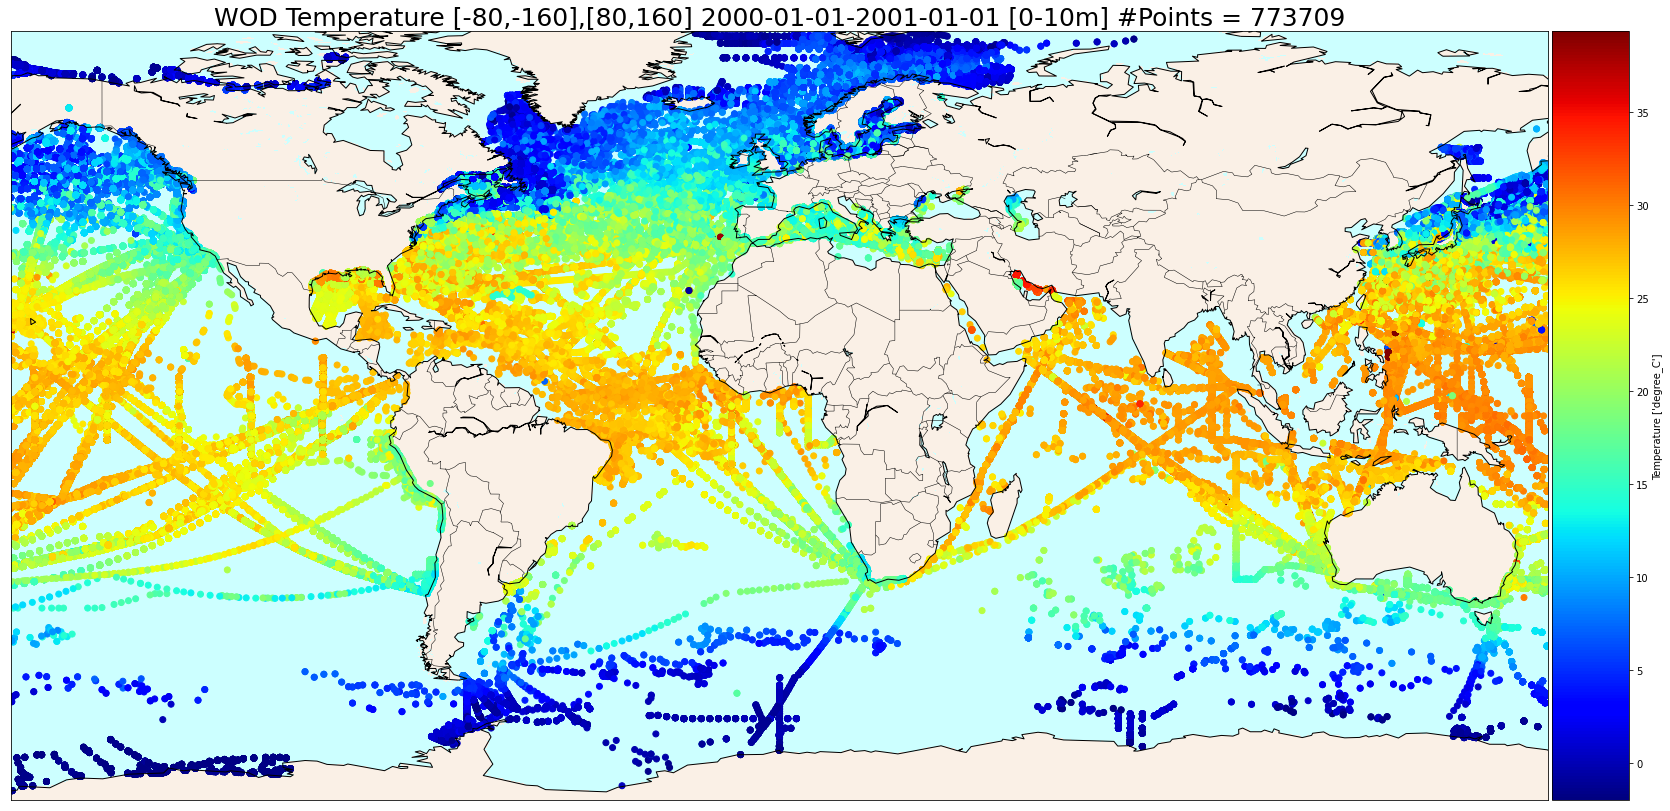

In [11]:
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(1, figsize = (29, 19))

m = Basemap(projection = 'cyl', llcrnrlon = minlon, llcrnrlat = minlat, urcrnrlon = maxlon, urcrnrlat = maxlat, resolution = 'c') 
m.drawlsmask(land_color = 'Linen', ocean_color = '#CCFFFF'); # can use HTML names or codes for colors
m.drawcoastlines()
m.drawcountries()

sc = m.scatter(df['LONGITUDE'], df['LATITUDE'], latlon = True, c = df[parameter], cmap = plt.cm.jet)

plt.title(f'WOD {parameter} {regionname} {mintemp.strftime("%Y-%m-%d")}-{maxtemp.strftime("%Y-%m-%d")} [{mindepth}-{maxdepth}m] #Points = {len(df)}', fontsize = 25)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "5%", pad = 0.05)
plt.colorbar(sc, cax = cax, label = f'{parameter} {unit}');
